In [14]:
import numpy as np

In [15]:
import galpy

In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [17]:
import matplotlib.pyplot as plt

In [20]:
M      = np.zeros((3,3))
M[0,:] = [-0.4776303088,-0.1738432154,0.8611897727]
M[1,:] = [ 0.510844589 ,-0.8524449229,0.111245042 ]
M[2,:] = [ 0.7147776536, 0.4930681392,0.4959603976]


In [22]:
def phi12_to_radec(phi1,phi2,degree=False):
    """
    Converting phi1 and phi2 to right ascension 
    and declination
    """
    
    phiXYZ = np.array([np.cos(phi2)*np.cos(phi1),
                          np.cos(phi2)*np.sin(phi1),
                          np.sin(phi2)])
    eqXYZ  = np.dot(M.T,phiXYZ)
    dec    = np.arcsin(eqXYZ[2])
    ra     = np.arctan2(eqXYZ[1],eqXYZ[0])
    
    if ra < 0.:
        ra += 2.*np.pi
    
    if degree == True:
        dec *= 180./np.pi
        ra  *= 180./np.pi
    return np.array([dec,ra])

In [25]:
def radec_to_xyz(dec,ra,degree=False):
    """
    Converting right ascension and declination to 
    cartesian coordinates
    """
    
    if degree == True:
        dec *= np.pi/180.
        ra  *= np.pi/180.
    
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(ra)

    return np.array([x,y,z])


def xyz_to_cyl(x,y,z):
    """
    Conversion of Cartesian coordinates to 
    cylindrical coordinates
    """
    
    R   = np.sqrt((x**2) + (y**2))
    phi = np.arctan(y/x)
    return np.array([R,z,phi])


def vxvyvz_to_vrvtvz(x,y,z,vx,vy,vz):
    """
    Conversion of velocities in Cartesian coordinates 
    to Cylindrical coordinates
    """
    R,z,phi = xyz_to_cyl(x,y,z)
    vr      =  vx * np.cos(phi) + vy * np.sin(phi)
    vt      = -vx * np.sin(phi) + vy * np.cos(phi)

    return np.array([vr,vt,vz])



In [26]:
#----------------------------------------------------------
#           Data in tables 1-4 of Koposov 2010
#----------------------------------------------------------

def table1_kop2010():
    """
    Table 1 of Koposov 2010, phi1 and radial velocities
    """
    
    phi1 = np.array([-45.23,-43.17,-39.54,-39.25,-37.95,
                     -37.96,-35.49,-35.27,-34.92,-34.74,
                     -33.74,-32.90,-32.25,-29.95,-26.61,
                     -25.45,-24.86,-21.21,-14.47,-13.73,
                     -13.02,-12.68,-12.55])
                     
    Vrad = np.array([28.8,29.3,2.9,-5.2,1.1,-11.7,-50.4,
                     -30.9,-35.3,-30.9,-74.3,-71.5,-71.5,
                     -92.7,-114.2,-67.8,-111.2,-144.4,
                     -179.0,-191.4,-162.9,-217.2,-172.2])
                     
    V_err = np.array([6.9,10.2,8.7,6.5,5.6,11.2,5.2,12.8,
                      7.5,9.2,9.8,9.6,9.2,8.7,7.3,7.1,
                      17.8,10.5,10.0,7.5,9.6,10.7,6.6])

    return phi1,Vrad,V_err



In [27]:
def table2_kop2010():
    """
    Table 2 of Koposov 2010, phi1 and phi2
    """

    phi1     = np.array([-60.,-56.,-54.,-48.,-44.,-40.,
                         -36.,-34.,-32.,-30.,-28.,-24.,
                         -22.,-18.,-12.,-2.])
                         
    phi2     = np.array([-0.64,-0.89,-0.45,-0.08,0.01,
                         -0.,0.04,0.06,0.4,0.08,0.03,
                         0.06,0.06,-0.05,-0.29,-0.87])
                         
    phi2_err = np.array([0.15,0.27,0.15,0.13,0.14,0.09,
                         0.10,0.13,0.06,0.10,0.12,0.05,
                         0.13,0.11,0.16,0.07])
    
    return phi1,phi2,phi2_err


def table3_kop2010():
    """
    Table 3 of Koposov 2010, phi1 and distance in kpc
    """
    
    phi1     = np.array([-55.,-45.,-35.,-25.,-15.,0.])
    dist     = np.array([7.2,7.59,7.83,8.69,8.91,9.86])
    dist_err = np.array([0.30,0.40,0.30,0.40,0.40,0.50])

    return phi1,dist,dist_err


def table4_kop2010():
    """
    Table 4 of Koposov 2010, phi1 and proper motion 
    in phi1 nd phi2 directions
    """

    phi1  = np.array([-55.,-45.,-35.,-25.,-15.])
    mu1   = np.array([-13.60,-13.10,-12.20,-12.60,-10.80])
    mu2   = np.array([-5.70,-3.30,-3.10,-2.7,-2.8])
    sigma = np.array([1.3,0.70,1.00,1.40,1.00])

    return phi1,mu1,mu2,sigma



In [29]:
import numpy            as     np
import matplotlib.pylab as     plt
from   galpy.util       import bovy_coords
from   galpy            import potential
from   galpy.orbit      import Orbit

In [30]:
def likelihood(x_model,x_data,x_err):
    """
    Returning log likelihood of the data
    """
    
    val = np.exp((-((x_model-x_data)**2))/(2.*(x_err**2)))
    return val

#----------------------------------------------------------
#            Coordinate tranformation of GD-1 data
#----------------------------------------------------------
phi1,phi2,phi2_err = table2_kop2010()
dec                = np.zeros(len(phi1))
ra                 = np.zeros(len(phi1))

# converting phi1 and phi2 to RA and DEC
for i in range(len(phi1)):
    dec[i],ra[i] = phi12_to_radec(phi1[i],phi2[i],degree=False)

# converting RA and DEC to xyz cartesian coordinates
x,y,z       = radec_to_xyz(dec,ra,degree=False)

# converting xyz cartesian coordinates to cylindrical coordinates
R,z_cyl,phi = xyz_to_cyl(x,y,z)

# converting cartesian velocities to cylindrical velocities
#vR,vt,vz    = vxvyvz_to_vrvtvz(x,y,z,vx,vy,vz)


#----------------------------------------------------------
#    Using galpy to initialize orbit and integrate it
#----------------------------------------------------------
p    = potential.LogarithmicHaloPotential(q=0.9,normalize=1)
vR   = p.Rforce(R,z_cyl,phi,t=0)

ts   = 1000 # number of timesteps
time = np.linspace(0.,1e2,ts)
o    = Orbit(vxvv=[1.,0.1,1.1,0.,0.1,0.],ro=8.,vo=220.) #initial condition of the orbit
#o    = Orbit(vxvv=[R,vR,vt,z_cyl,vz,phi],ro=8.,vo=220.)
o.integrate(time,p)


plt.ion()
o.plot()

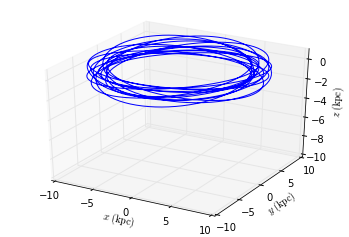

In [32]:
o.plot3d()

This is a cool plot!
